In [1]:
from swemnics.problems import SlopedBeachProblem
from swemnics import solvers as Solvers
from mpi4py import MPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dolfinx import fem as fe
import pickle
from tqdm import tqdm

import pandas as pd
from scipy.optimize import minimize
import seaborn as sns
from typing import Callable, Dict, List, Tuple, Any, Union

from plotting import plot_simulation_results, create_comparison_figure
from fourd_var import*
from dca_utils import*

sns.set_palette("bright")
plt.style.use("mystyle1.mplstyle")


In [2]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()


problem_params = {
    'dt': 600,
    't': 0,
    't_final': 7*24*60*60,
    'num_steps': int(np.ceil((7*24*60*60)/600)),
    'num_windows': 4,
    'fric_law': 'mannings',    #friction law either quadratic or linear
    'sol_var': 'h'             #solution variable either h or hu
}

solver_params = {"rtol": 1e-5,
          "atol": 1e-6,
          "max_it":10,
          "relaxation_parameter":1.0,
          "ksp_type": "gmres",
          "pc_type": "ilu",
          "ksp_ErrorIfNotConverged": False
          }#,"pc_factor_mat_solver_type":"mumps"}



In [3]:
assert problem_params['num_steps'] == int(np.ceil(problem_params['t_final']/problem_params['dt']))
true_signal, prob, stations, state_coords = get_true_signal(problem_params,'sloped_beach', solver_params, create_problem_solver, 4)

Location of shoreline: 13800
Fully conservative flux
Fully conservative flux
WD nonspherical

Fully conservative flux


In [4]:
true_signal.vals.shape, true_signal.u.x.array.shape, stations.shape, state_coords.shape

((1009, 108, 3), (1296,), (108, 3), (432, 3))

In [5]:
true_signal.vals[:,:,0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.59244655e-05,  2.58287287e-05,  2.58287287e-05, ...,
         1.19973720e-03,  9.36991025e-04,  9.36991025e-04],
       [ 2.25124757e-04,  2.24889719e-04,  2.24889719e-04, ...,
         4.80613745e-03,  3.99376838e-03,  3.99376838e-03],
       ...,
       [-1.27580575e+00, -1.27942990e+00, -1.27942990e+00, ...,
        -3.46891129e-01, -3.78574475e-01, -3.78574475e-01],
       [-1.26407461e+00, -1.26836475e+00, -1.26836475e+00, ...,
        -1.73916280e-01, -2.05050269e-01, -2.05050269e-01],
       [-1.23253999e+00, -1.23995268e+00, -1.23995268e+00, ...,
         3.79674465e-04, -2.98795638e-02, -2.98795638e-02]],
      shape=(1009, 108))

In [6]:
obs_frequency=4
obs_std=1.9
total_steps = int((problem_params['t_final']/problem_params['dt']) + 1)
problem_params['num_steps'] = int(np.ceil((7*24*60*60)/600)/problem_params['num_windows']) # Size of each assimilation window
obs_per_window = problem_params['num_steps'] // obs_frequency

obs_indices_per_window, obs_indices = setup_observation_indices(problem_params['num_steps'], obs_frequency, total_steps)

# Create synthetic observations
H = build_observation_matrix(prob, true_signal, stations)
hb = 5.0 / 13800 * (13800 - stations[:, 0])
y_obs = generate_observations(true_signal, hb, obs_indices, obs_std)

# Generate Background,Observation, and Predicted Error Covariance Matrices
state_dim = true_signal.problem.h_b.x.array.shape[0]
obs_dim = stations.shape[0]
R = np.eye(obs_dim) * (obs_std**2)

inflation_factor=4
B = inflation_factor*np.eye(state_dim) 


# Get Predicted Covariance
# P = H @ B @ H.T 
P =  np.eye(obs_dim)

# Get Inverse Covariance matrices
R_inv = np.linalg.inv(R)
B_inv = np.linalg.inv(B) 
P_inv = np.linalg.inv(P)

In [7]:
H.shape

(108, 432)

In [8]:
print(f"max:{H.max()}, "
      f"min: {H.min()}, "
      f"2-norm: {np.linalg.norm(H, ord=2)}, "
      f"cond #: {np.linalg.cond(H)}, "
      f"rank: {np.linalg.matrix_rank(H)}")

max:1.0000000000000016, min: -1.5817299161268318e-15, 2-norm: 1.7320508075688776, cond #: inf, rank: 74


In [9]:
H.shape

(108, 432)

In [10]:
# set anything below 1e-10 to zero
H[np.abs(H) < 1e-10] = 0

In [14]:
print(f"max:{H.max()}, "
      f"min: {H.min()}, "
      f"2-norm: {np.linalg.norm(H, ord=2)}, "
      f"cond #: {np.linalg.cond(H)}, "
      f"rank: {np.linalg.matrix_rank(H)}")

max:1.0000000000000016, min: 0.0, 2-norm: 1.7320508075688776, cond #: inf, rank: 74


In [16]:
H_trunc = H[:74,:]

In [17]:
print(f"max:{H_trunc.max()}, "
      f"min: {H_trunc.min()}, "
      f"2-norm: {np.linalg.norm(H_trunc, ord=2)}, "
      f"cond #: {np.linalg.cond(H_trunc)}, "
      f"rank: {np.linalg.matrix_rank(H_trunc)}")

max:1.0000000000000016, min: 0.0, 2-norm: 1.7320508075688774, cond #: inf, rank: 52


In [15]:
# find which rows of H are linearly dependent
rank_H = np.linalg.matrix_rank(H)
if rank_H < H.shape[0]:
    print("Rows of H are linearly dependent")
    # Find the linearly dependent rows
    dependent_rows = np.where(np.abs(np.linalg.svd(H, compute_uv=False) - 0) < 1e-10)[0]
    print(f"Dependent rows: {dependent_rows}")
else:
    print("Rows of H are linearly independent")
# Find the null space of H  


Rows of H are linearly dependent
Dependent rows: [ 74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]


In [9]:
Hnull_space = np.linalg.svd(H)[2][rank_H:]
print(f"Null space of H: {Hnull_space}")
# Check if the null space is orthogonal to the range of H
orthogonal_check = np.allclose(H @ Hnull_space.T, 0)
print(f"Orthogonal check: {orthogonal_check}")
# # Check if the null space is orthogonal to the range of H
# print(f"Null space of H: {Hnull_space}")
# # Check if the null space is orthogonal to the range of H
# print(f"Null space of H: {Hnull_space}")

Null space of H: [[ 0.00000000e+00  0.00000000e+00  5.08869326e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.58172992e-15  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.30570506e-01
   4.95156082e-01  4.89501992e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.95156082e-01
   5.69429494e-01  5.62927291e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.57912251e-16
  -5.60196012e-16  0.00000000e+00]]
Orthogonal check: True


In [87]:
np.linalg.matrix_rank(H[:48,:])

np.int64(42)

In [95]:
H[47,:].sum()

np.float64(1.0)

In [90]:
np.where(H[47,:] != 0)[0]

array([346, 347])

In [5]:
# H[47,:]

In [99]:
H[47,346], H[47,347]

(np.float64(-3.789561257387201e-16), np.float64(1.0000000000000004))

In [6]:
# H[49,:]

In [73]:
# find which rows of H are linearly independent
rank_H = np.linalg.matrix_rank(H)
independent_rows = np.where(np.abs(H) > 1e-10)[0]
independent_rows = np.unique(independent_rows)
print(f"Rank of H: {rank_H}")
print(f"Independent rows of H: {independent_rows}")
# Get the number of independent rows
num_independent_rows = len(independent_rows)
print(f"Number of independent rows: {num_independent_rows}")


Rank of H: 48
Independent rows of H: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53]
Number of independent rows: 54


In [7]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 10,
    "legend.frameon": False,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.labelsize": 10,
    "axes.labelpad": 5,
    "axes.titlesize": 10,
    "figure.figsize": (4, 2),
}

# with plt.rc_context(rc=plot_params):
#     sns.heatmap(H, cmap="viridis") 
#     plt.title("Matrix H")
#     plt.show()

In [8]:
# np.real(np.linalg.eigvals(H.T@H))

In [ ]:
inflation_factor=10
B = inflation_factor*np.eye(state_dim) 
P = H @ B @ H.T 
np.all(np.linalg.eigvals(P) > 0)

np.False_

In [44]:
eigenvalues = np.linalg.eigvals(P)
negative_eigenvalues = eigenvalues[eigenvalues < 0]
np.real(negative_eigenvalues)

array([-1.61846990e-15, -7.10542736e-15])

In [78]:
# sum first row of H

i = 0
for row in H:
    if row.sum() != 1.0:
        print(f"Row idx: {i}, Row sum: {row.sum()}")
    i += 1


Row idx: 20, Row sum: 0.9999999999999999
Row idx: 29, Row sum: 0.9999999999999999
Row idx: 38, Row sum: 0.9999999999999999
Row idx: 50, Row sum: 0.9999999999999999
Row idx: 53, Row sum: 0.9999999999999999


In [ ]:
obs_indices_per_window[:-1].shape, y_obs.shape

(62,)

In [7]:
bayes_analysis = run_assimilation(problem_params, solver_params, stations, y_obs, obs_per_window,
                             obs_indices_per_window,
                             H, B_inv, R_inv, P_inv, hb,
                             'sloped_beach',
                             create_problem_solver,
                             bayes_cost_function,
                             grad_bayes_cost_function
                             )

Processing windows:   0%|          | 0/4 [00:00<?, ?window/s]

Location of shoreline: 13800
Fully conservative flux
Fully conservative flux
WD nonspherical

Fully conservative flux
Solver Time 1: 0
J_b: 0.0, J_o: 15918.110240954164
J_b: 1.7347234730312863e-16, J_o: 15918.110244370151
J_b: 2.7087816932918995e-15, J_o: 15918.110236764453
J_b: 2.219177971478174e-06, J_o: 15918.13095647594
J_b: 5.547944928695368e-07, J_o: 15918.120607615147
J_b: 1.386986232173712e-07, J_o: 15918.115408421534
J_b: 3.4674655804336396e-08, J_o: 15918.112824532873
J_b: 8.668663951091191e-09, J_o: 15918.111530527378
J_b: 2.167165987770519e-09, J_o: 15918.110885422971
J_b: 5.417914969417015e-10, J_o: 15918.11055937434
J_b: 0.0, J_o: 15918.110237635046
Optimization completed:
  Success: False
  Status: 3
  Message: Max. number of function evaluations reached
  Final cost: 15918.110237635046
  Iterations: 0
  Function evaluations: 11
  Initial state: [1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1

Processing windows:  25%|██▌       | 1/4 [02:30<07:31, 150.59s/window]

Location of shoreline: 13800
Fully conservative flux
Fully conservative flux
WD nonspherical

Fully conservative flux
Solver Time 1: 151200
J_b: 0.0, J_o: 16349.73869159851
J_b: 3.6392988357695536e-17, J_o: 16349.738909713706
J_b: 6.86245130674831e-06, J_o: 16349.79208049274
J_b: 1.7156128266870738e-06, J_o: 16349.760308447445
J_b: 4.289032066717656e-07, J_o: 16349.74954099074
J_b: 1.0722580166794673e-07, J_o: 16349.744054052147
J_b: 2.680645041698508e-08, J_o: 16349.741373612647
J_b: 6.70161260424654e-09, J_o: 16349.738661103987
J_b: 1.6754031510614611e-09, J_o: 16349.739317966225
J_b: 4.1885078776542447e-10, J_o: 16349.739099149396
J_b: 0.0, J_o: 16349.73869159851
Optimization completed:
  Success: False
  Status: 3
  Message: Max. number of function evaluations reached
  Final cost: 16349.73869159851
  Iterations: 0
  Function evaluations: 11
  Initial state: [ 4.21593698e-01  4.45048755e-01  3.77212741e-01  3.76415579e-01
  3.77440653e-01  3.28290395e-01  2.34811660e-01  4.21913590

Processing windows:  50%|█████     | 2/4 [06:34<06:50, 205.28s/window]

Location of shoreline: 13800
Fully conservative flux
Fully conservative flux
WD nonspherical

Fully conservative flux
Solver Time 1: 302400


Processing windows:  50%|█████     | 2/4 [06:35<06:35, 197.64s/window]


KeyboardInterrupt: 

In [7]:
# bayes_analysis = run_assimilation(problem_params, solver_params,
#                                   stations, y_obs, obs_per_window,
#                                   obs_indices_per_window,
#                                   H, B_inv, R_inv, P_inv, hb, 'sloped_beach',
#                                  create_problem_solver, bayes_cost_function)

In [13]:
bayes_rmse = np.sqrt(np.mean((true_signal.vals[:,:,0] - bayes_analysis[:,:,0]) ** 2))
bayes_rmse

np.float64(0.011056721457277952)

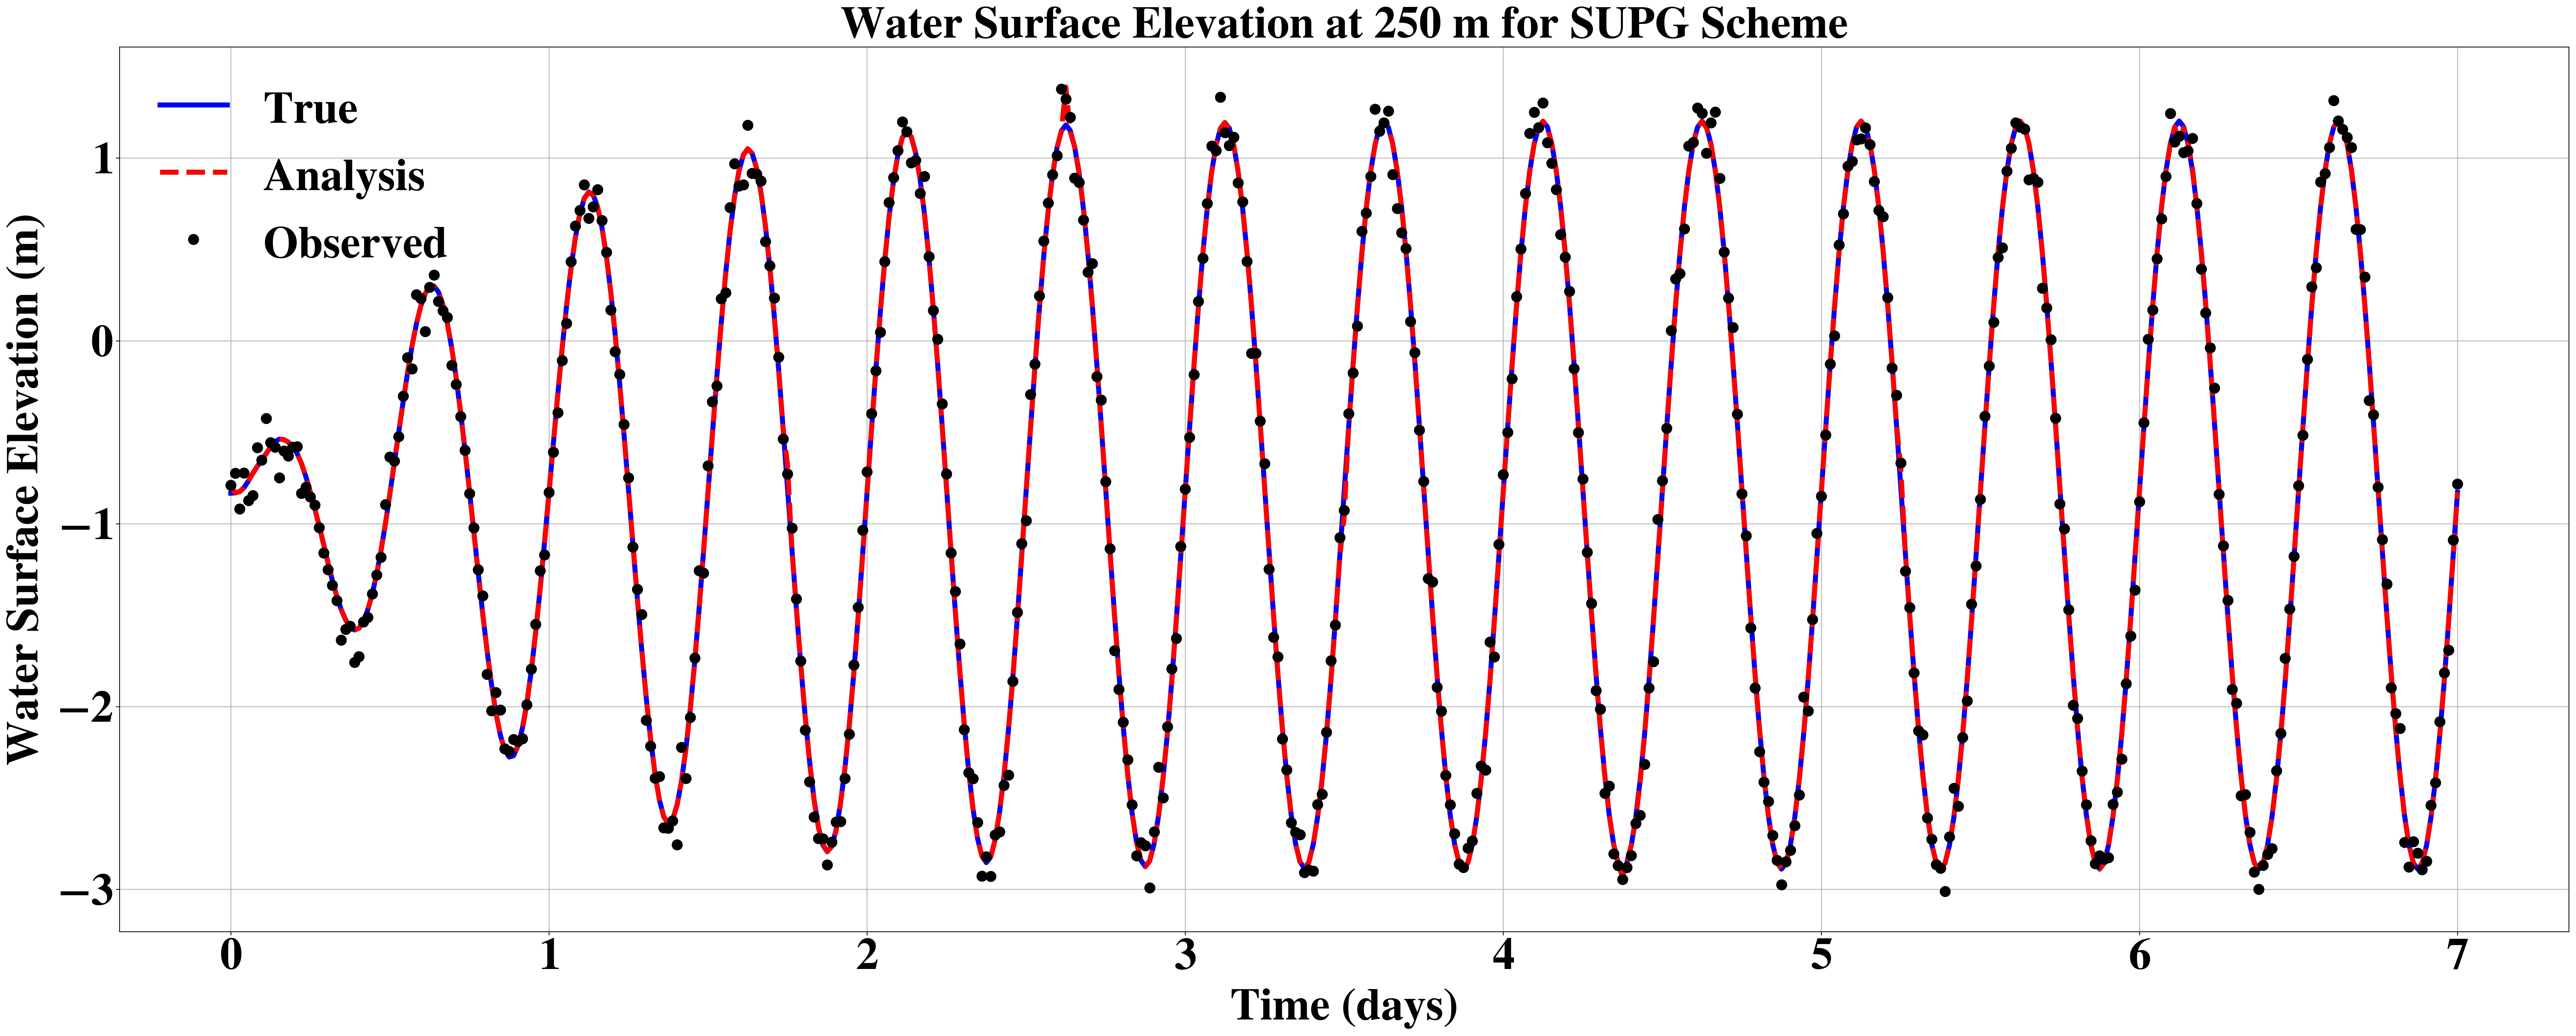

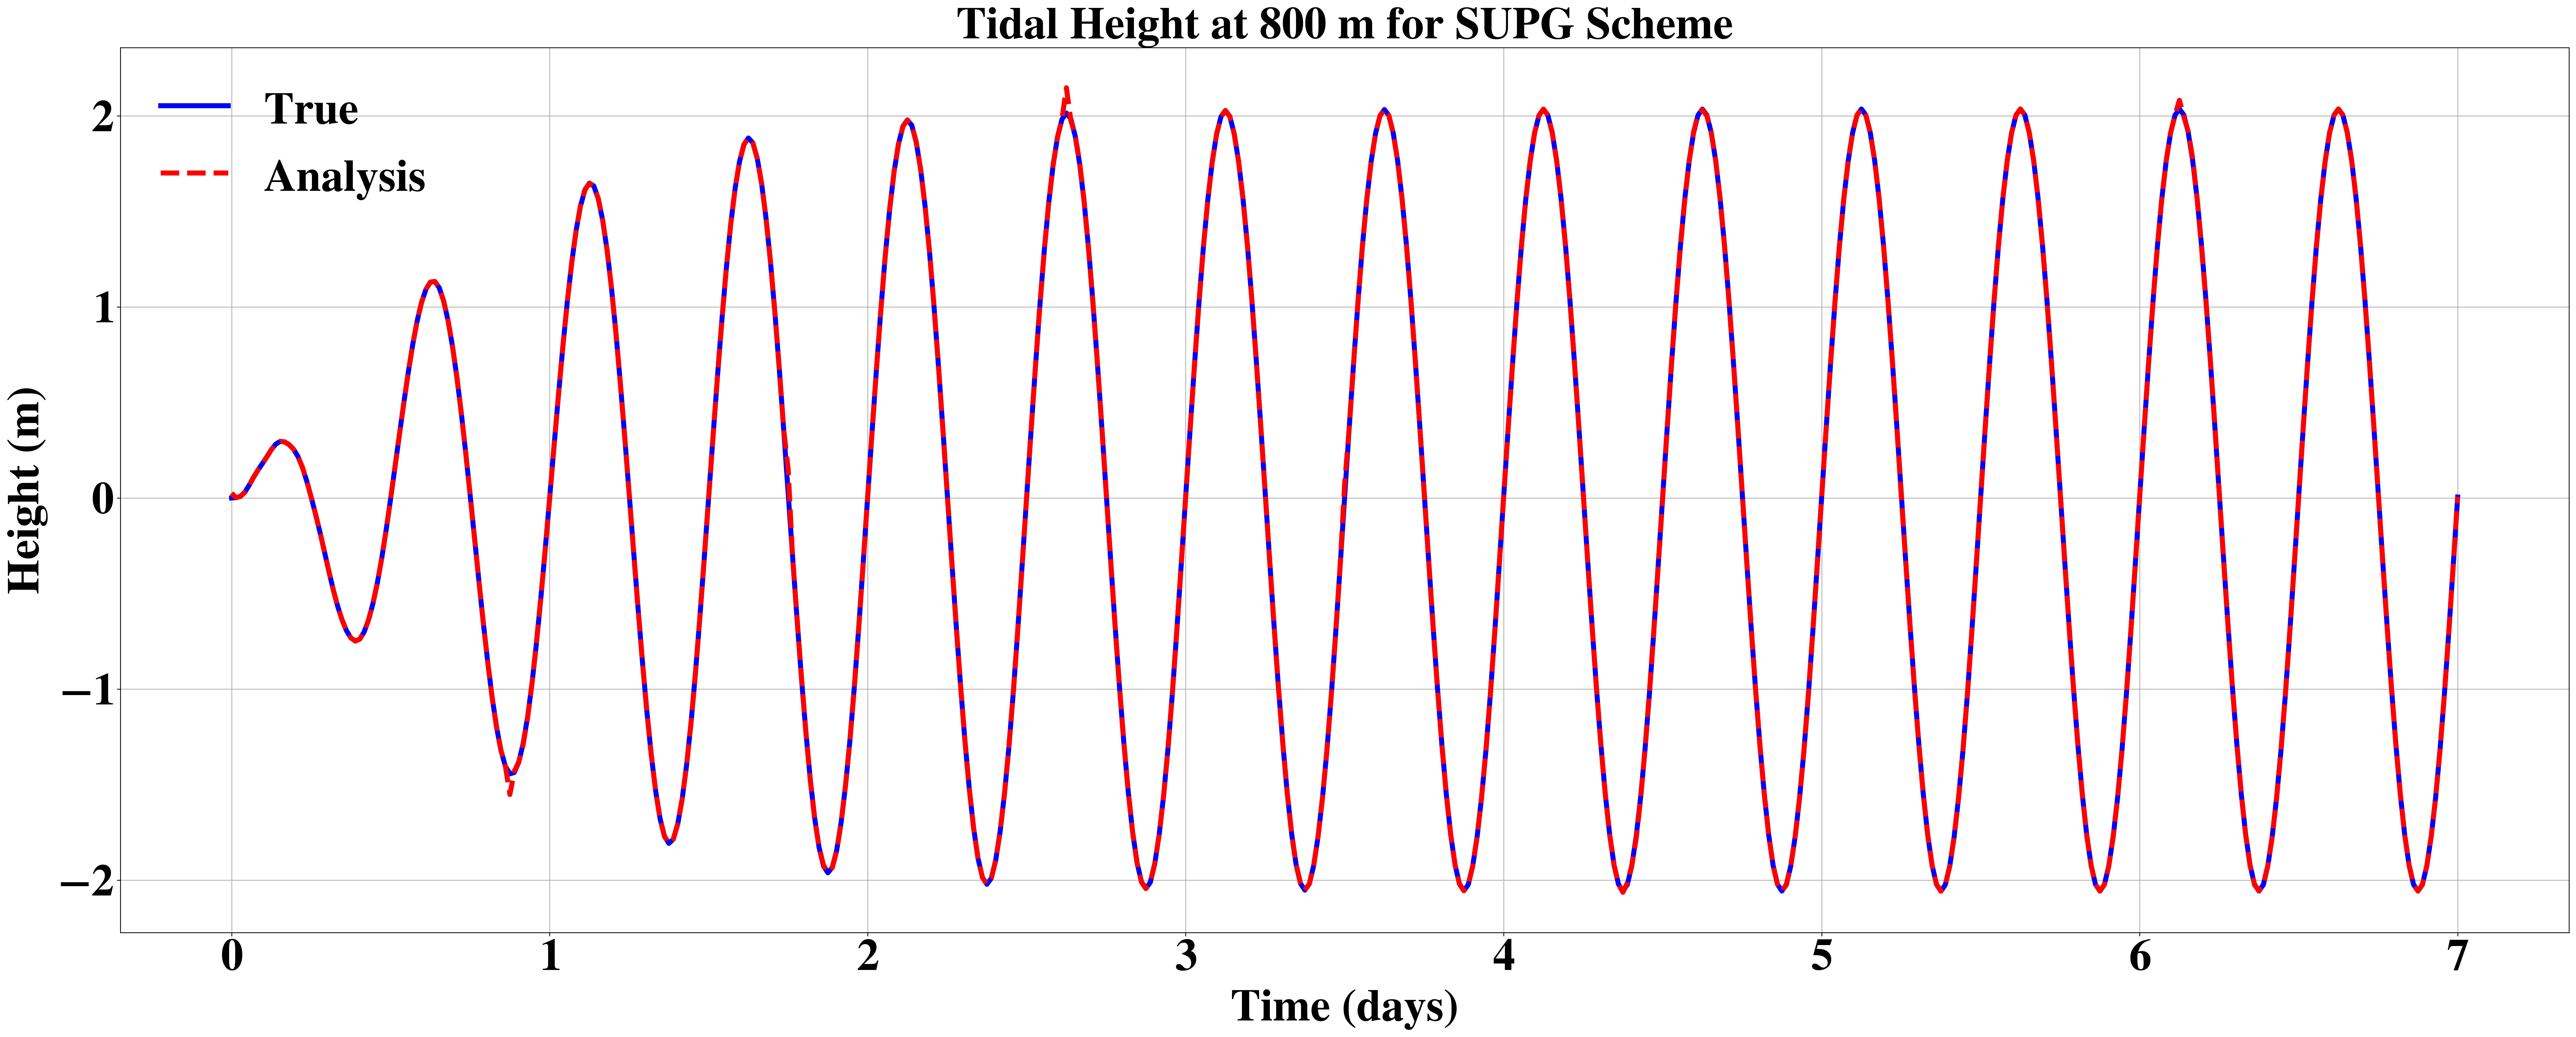

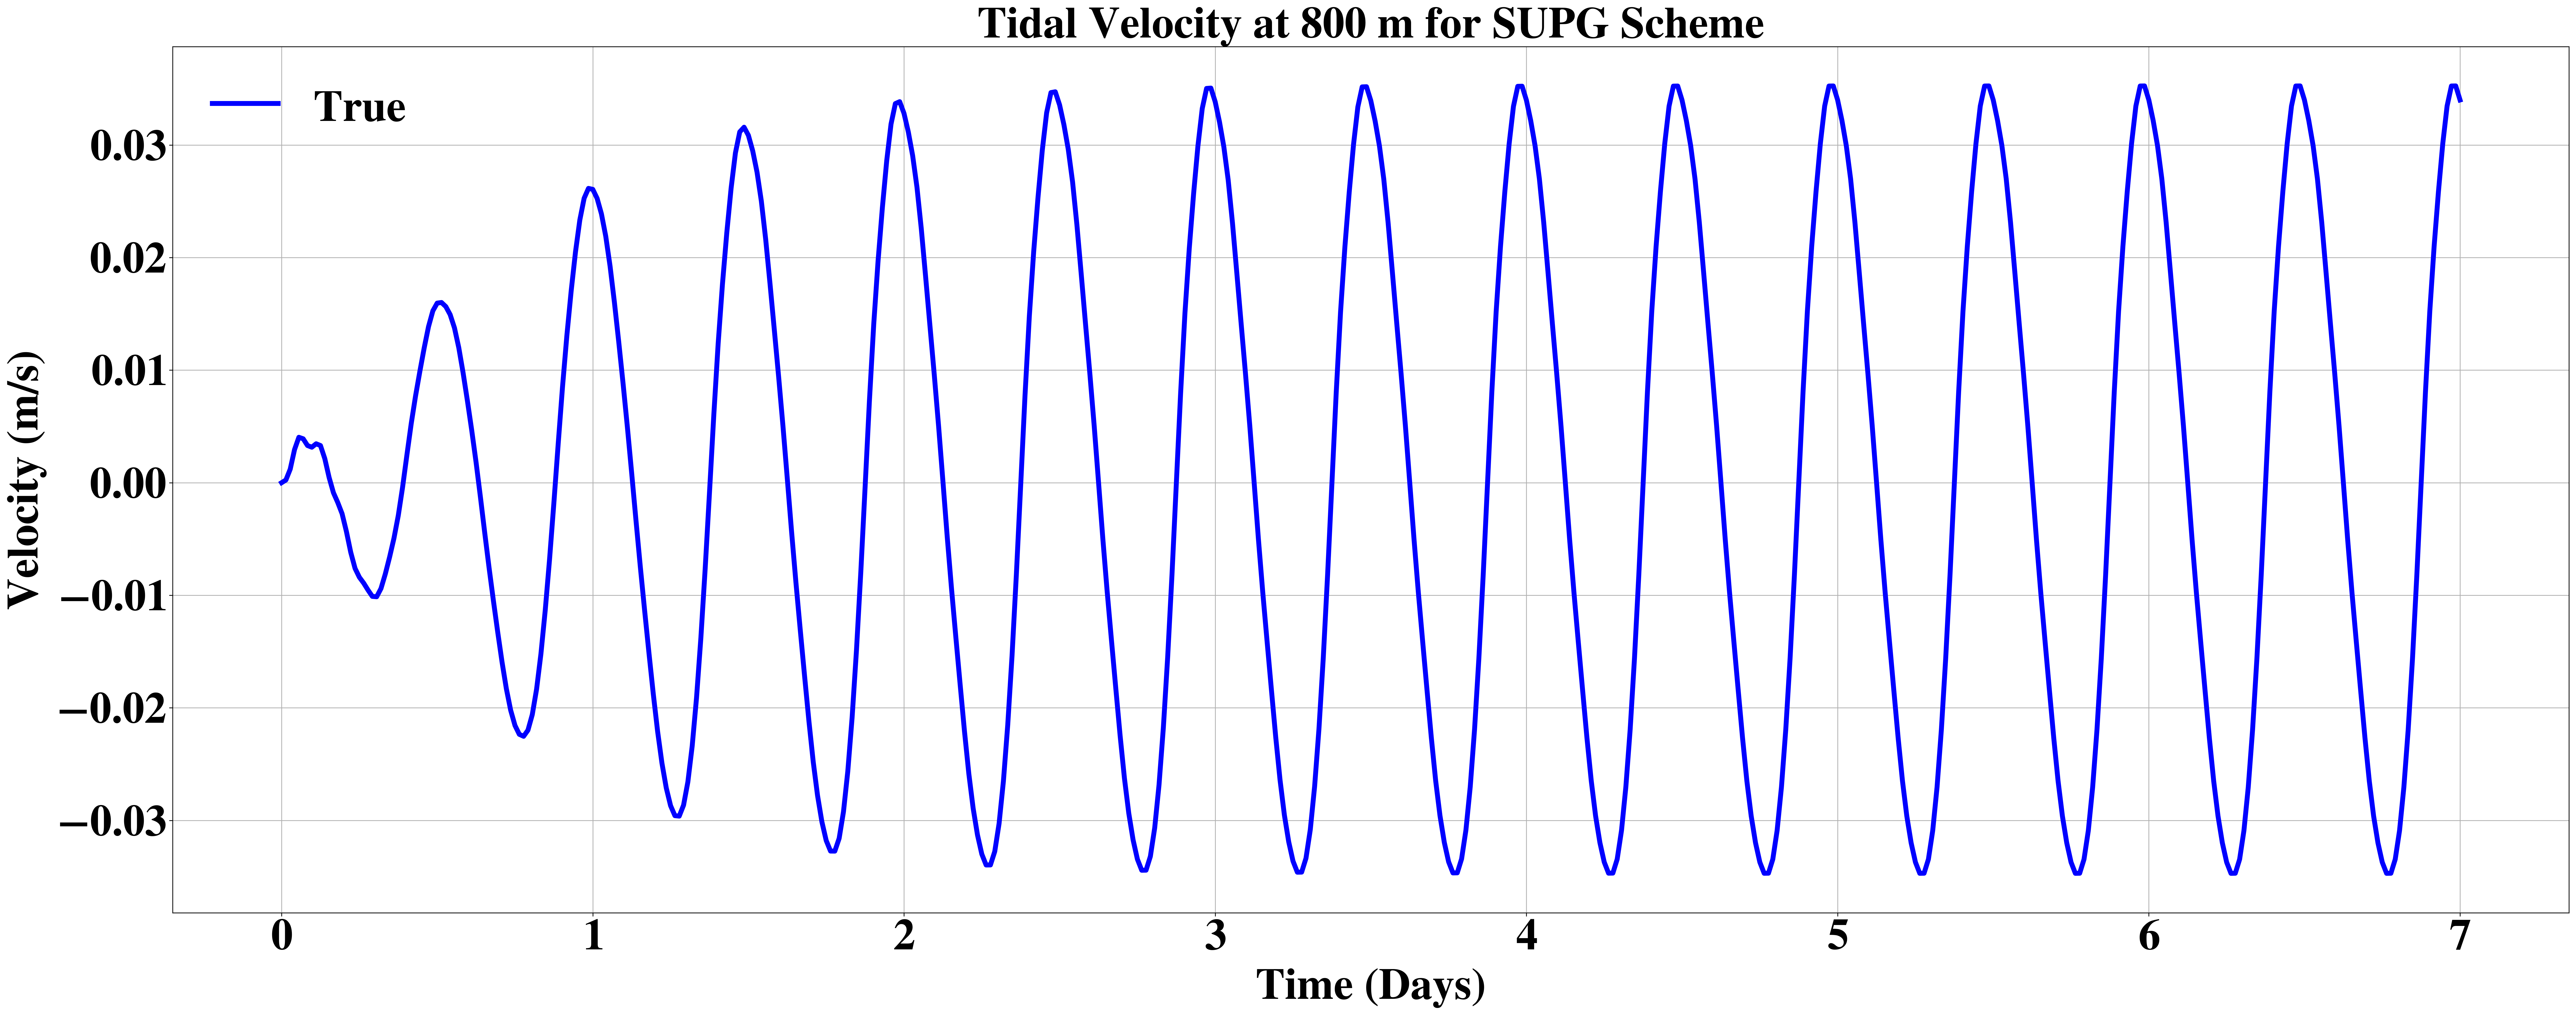

In [16]:
plot_params = {
    "lines.linewidth": 5,
    "lines.markersize": 10,
    'lines.markeredgecolor': 'black',
    "legend.fontsize": 45,
    "legend.frameon": False,
    "xtick.labelsize": 45,
    "ytick.labelsize": 45,
    "axes.labelsize": 45,
    "axes.labelpad": 10,
    "axes.titlesize": 45,
    "figure.figsize": (44, 16),
}


plot_simulation_results(true_signal, bayes_analysis, y_obs, hb, problem_params,
                       obs_indices, plot_params, station_idx=5, save=False, save_prefix="bayes_")

In [ ]:
filenames = ["wse", "xvel", "yvel"]

for i, filename in enumerate(filenames):
	with open(f"{name}_p1_{filename}.pkl", 'wb') as f:
		pickle.dump(solver.vals[:,:,i], f)

# np.savetxt(f"{name}_p1_wse.csv", solver.vals[:,:,0], delimiter=",")
# np.savetxt(f"{name}_p1_xvel.csv", solver.vals[:,:,1], delimiter=",")
# np.savetxt(f"{name}_p1_yvel.csv", solver.vals[:,:,2], delimiter=",")

In [15]:
wse_df = pd.read_csv(f"{name}_p1_wse.csv", header=None)

In [17]:
wse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1009 non-null   float64
 1   1       1009 non-null   float64
 2   2       1009 non-null   float64
 3   3       1009 non-null   float64
 4   4       1009 non-null   float64
 5   5       1009 non-null   float64
 6   6       1009 non-null   float64
 7   7       1009 non-null   float64
 8   8       1009 non-null   float64
 9   9       1009 non-null   float64
 10  10      1009 non-null   float64
 11  11      1009 non-null   float64
 12  12      1009 non-null   float64
 13  13      1009 non-null   float64
 14  14      1009 non-null   float64
 15  15      1009 non-null   float64
dtypes: float64(16)
memory usage: 126.3 KB


In [ ]:
def background_loss(z, z_b, B_inv):
    """Calculate the background loss term."""
    diff_b = z - z_b
    return 0.5 * np.dot(diff_b, np.dot(B_inv, diff_b))


def observation_loss(Qz, y_obs, R_inv):
    """Calculate the observation loss term."""
    obs_diff = (Qz - y_obs).T
    return 0.5 * np.sum(obs_diff * (R_inv @ obs_diff))



def get_trajectory_observations(
    z, obs_indices, solver_params, stations, hb, wse_0, V, solver
):
    """Propagate state through model and get observations."""

    # Convert initial state vector in h space to full initial state vector in u space
    u_0 = fe.Function(V)
    h_0 = u_0.sub(0)  # just water depth
    h_b = solver.problem.h_b  # bathymetry

    wse_0.x.array[:] = z

    """ 
    - Make sure z node order matches node order of wse_0
    
    """

    h_0.interpolate(fe.Expression(wse_0 + h_b, V.sub(0).element.interpolation_points()))

    u_0.sub(0).interpolate(h_0)

    solver.time_loop(solver_parameters=solver_params, stations=stations, u_0=u_0)

    trajectory = solver.vals[:, :, 0]  # get h
    wse = trajectory - hb  # convert h to wse
    wse_obs = wse[obs_indices]  # get wse at observed times

    return wse_obs



def _setup_function_spaces(solver, init_time):
    """
    Set up common environment for all cost functions
    """
    # solver.problem.t = init_time
    V = solver.V
    h_b = solver.problem.h_b
    V_scalar = h_b._V
    wse_0 = fe.Function(V_scalar)

    return V, h_b, V_scalar, wse_0


def bayes_cost_function(
    z,
    z_b,
    y_obs,
    obs_indices,
    H,
    B_inv,
    R_inv,
    P_inv,
    Q_zb,
    solver_params,
    stations,
    hb,
    solver,
    init_time,
):
    """
    Vectorized cost function for standard 4D-Var with a generic model.
    """
    # Set up environment
    V, _, _, wse_0 = _setup_function_spaces(solver, init_time)
    solver.problem.t = init_time
    # Compute background loss term
    J_b = background_loss(z, z_b, B_inv)

    # Get model trajectory observations
    Qz = get_trajectory_observations(
        z, obs_indices, solver_params, stations, hb, wse_0, V, solver
    )

    # Compute observation loss term
    J_o = observation_loss(Qz, y_obs, R_inv)

    return J_b + J_o

In [ ]:
# Conversion to check. 

# Conversion to check. 
